In [1]:
from dataset import NiiFolder

import torch 
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils, datasets
from transforms import RandomHorizontalFlip3D

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

## Глобальные переменные

In [2]:
#global
in_channels = 3
num_classes = 2
epochs = 10
lr = 0.001
batch_size = 10
beta1 = 0.5

dataroot = "/data/metastasises-ws/data/metastasises_dataset/train3D/"
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

## Сеть на основе LeNet, но с 3D свертками

In [3]:
class LeNet3D(nn.Module):
    def __init__(self):
        super(LeNet3D, self).__init__()
        
        self.pool = nn.AvgPool3d(kernel_size=(1, 3, 3))

        self.conv1 = nn.Conv3d(3, 6, kernel_size=(2,32,32))
        self.conv2 = nn.Conv3d(6, 16, kernel_size=(2,16,16))
        self.conv3 = nn.Conv3d(16, 32, kernel_size=(2,8,8))
        self.conv4 = nn.Conv3d(32, 64, kernel_size=(2,4,4))
#         self.conv5 = nn.Conv3d(64, 128, kernel_size=(2,4,4))
        
        self.fc1 = nn.Linear(9216, 16 * 5 * 5 * 5)
        self.fc2 = nn.Linear(16 * 5 * 5 * 5, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
#         print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
#         print(x.shape)
        x = self.pool(F.relu(self.conv3(x)))
#         print(x.shape)
        x = self.pool(F.relu(self.conv4(x)))
#         print(x.shape)
        x = x.view(-1, 9216)
#         print(x.shape)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [4]:
def valid(model, dataloader, criterion):
    model.eval()
    loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data[0].float().to(device), data[1].to(device)
        y_pred = model(inputs)
        loss += criterion(y_pred, labels)
        
    model.train()    
    return loss.item()/len(dataloader.dataset)

def train(model, dataloader, optimizer, val_dataloader = None, criterion = nn.CrossEntropyLoss(), epochs = 20, device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")):
    model.train()
    losses = []
    val_losses = []
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_corrects = 0.0

        for i, data in enumerate(dataloader, 0):
            inputs, labels = data[0].float().to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_corrects += torch.sum(predicted == labels.data)

            running_loss += loss.item()
            losses.append(loss.item()/batch_size)
            
            if val_dataloader: 
                val_losses.append(valid(model, val_dataloader, criterion))

            if i % 5 == 0:
                if val_dataloader:
                    v_loss = valid(model, val_dataloader, criterion)
                    print('[epoch %d, batch %5d] loss: %.3f, correct: %.3f, val_loss: %.3f' % (epoch + 1, i + 1, running_loss / (5*batch_size), running_corrects / (5*batch_size), v_loss))                                        
                else: 
                    print('[epoch %d, batch %5d] loss: %.3f, correct: %.3f' % (epoch + 1, i + 1, running_loss / 5, running_corrects / 5))
                running_loss = 0.0
                running_corrects = 0.0
        print('[epoch %d] loss: %.3f, correct: %.3f, val_loss: %.3f' % (epoch+1, running_loss/len(dataloader.dataset), running_corrects/len(dataloader.dataset), valid(model, val_dataloader, criterion)))
        

    print('Finished Training')
    if val_dataloader: return losses, val_losses
    return losses

In [5]:
# model = LeNet3D().to(device)
# x = Variable(torch.randn(3, 3, 20, 512, 512)).to(device) # (N,C,D,H,W)
# y = model(x)
# print(y.shape)

In [5]:
def valid(model, dataloader, criterion):
    model.eval()
    loss = 0.0
    corrects = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data[0].float().to(device), data[1].to(device)
        y_pred = model(inputs)
        _, predicted = torch.max(y_pred.data, 1)
        corrects += torch.sum(predicted == labels.data).item()
        loss += criterion(y_pred, labels)
        
    model.train()    
    return loss.item()/len(dataloader.dataset), corrects/len(dataloader.dataset)

def train(model, dataloader, optimizer, val_dataloader = None, criterion = nn.CrossEntropyLoss(), epochs = 20, device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")):
    model.train()
    losses = []
    val_losses = []
    
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_corrects = 0.0

        for i, data in enumerate(dataloader, 0):
            inputs, labels = data[0].float().to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_corrects += torch.sum(predicted == labels.data).item()
#             print( running_corrects.item())

            running_loss += loss.item()
            losses.append(loss.item()/batch_size)
            
            if val_dataloader: 
                val_loss, val_corr = valid(model, val_dataloader, criterion)
                val_losses.append(val_loss)
                
        val_loss, val_corr = valid(model, val_dataloader, criterion)        
        print('[epoch %d] loss: %.3f, correct: %.3f, val_loss: %.3f, val_corr: %.3f' % (epoch+1, running_loss/len(dataloader.dataset), running_corrects/len(dataloader.dataset), val_loss, val_corr))
        

    print('Finished Training')
    if val_dataloader: return losses, val_losses
    return losses

Объявим датасет и обучим

In [6]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.shape).numpy() * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    
nii_transforms = transforms.Compose([
#     transforms.RandomVerticalFlip(), не работает
#     transforms.RandomResizedCrop(256, scale=(5.0, 10.0)), не работает
    RandomHorizontalFlip3D(),
    AddGaussianNoise()
#     transforms.ToTensor()
])


full_dataset =  NiiFolder(dataroot, transform = nii_transforms)

train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader =  DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader =  DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [8]:
model = LeNet3D().to(device)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

optimizer = optim.Adam(model.parameters(), lr = 1e-4)
criterion = nn.MSELoss()

losses, val_losses = train(model, train_loader, optimizer, device = device, val_dataloader = test_loader)

[epoch 1] loss: 0.077, correct: 0.571, val_loss: 0.099, val_corr: 1.000
[epoch 2] loss: 0.071, correct: 0.571, val_loss: 0.109, val_corr: 1.000
[epoch 3] loss: 0.071, correct: 0.571, val_loss: 0.105, val_corr: 1.000
[epoch 4] loss: 0.070, correct: 0.571, val_loss: 0.107, val_corr: 1.000
[epoch 5] loss: 0.070, correct: 0.571, val_loss: 0.107, val_corr: 1.000
[epoch 6] loss: 0.071, correct: 0.571, val_loss: 0.090, val_corr: 1.000
[epoch 7] loss: 0.067, correct: 0.633, val_loss: 0.109, val_corr: 0.833
[epoch 8] loss: 0.069, correct: 0.633, val_loss: 0.098, val_corr: 1.000
[epoch 9] loss: 0.063, correct: 0.694, val_loss: 0.078, val_corr: 0.667
[epoch 10] loss: 0.061, correct: 0.633, val_loss: 0.087, val_corr: 0.667
[epoch 11] loss: 0.054, correct: 0.796, val_loss: 0.076, val_corr: 0.667
[epoch 12] loss: 0.055, correct: 0.735, val_loss: 0.129, val_corr: 0.333
[epoch 13] loss: 0.067, correct: 0.673, val_loss: 0.105, val_corr: 0.667
[epoch 14] loss: 0.057, correct: 0.755, val_loss: 0.094, val

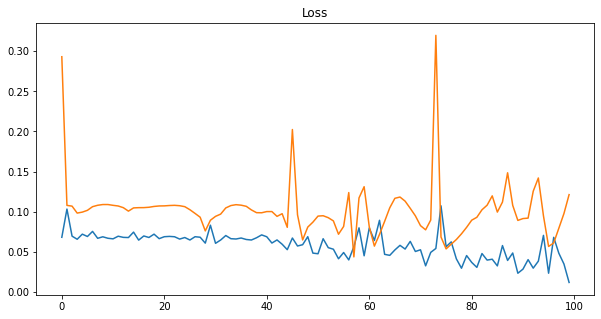

In [9]:
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(losses,label="train_loss")
plt.plot(val_losses,label="val_loss")

In [10]:
torch.save(model.state_dict(),"./models/LeNet3D_20eph.pth")

In [14]:
#random fold
full_dataset =  NiiFolder(dataroot, transform = nii_transforms)
losses = []
val_losses = []
for i in range(5):
    print("--- Start of random-fold", i,"---")
    train_size = int(0.9 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    train_loader =  DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader =  DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    model = LeNet3D().to(device)
    optimizer = optim.SGD(model.parameters(), lr = 0.001)

    loss, val_loss = train(model, train_loader, optimizer, device = device, val_dataloader = test_loader, epochs = 5)
    losses.append(loss)
    val_losses.append(val_loss)

--- Start of random-fold 0 ---
[epoch 1] loss: 0.071, correct: 0.449, val_loss: 0.116, val_corr: 0.667
[epoch 2] loss: 0.071, correct: 0.653, val_loss: 0.115, val_corr: 0.500
[epoch 3] loss: 0.072, correct: 0.571, val_loss: 0.114, val_corr: 0.667
[epoch 4] loss: 0.070, correct: 0.612, val_loss: 0.113, val_corr: 0.667
[epoch 5] loss: 0.070, correct: 0.612, val_loss: 0.114, val_corr: 0.667
Finished Training
--- Start of random-fold 1 ---
[epoch 1] loss: 0.072, correct: 0.510, val_loss: 0.116, val_corr: 0.500
[epoch 2] loss: 0.070, correct: 0.592, val_loss: 0.119, val_corr: 0.333
[epoch 3] loss: 0.071, correct: 0.510, val_loss: 0.116, val_corr: 0.500
[epoch 4] loss: 0.070, correct: 0.612, val_loss: 0.115, val_corr: 0.667
[epoch 5] loss: 0.069, correct: 0.673, val_loss: 0.118, val_corr: 0.167
Finished Training
--- Start of random-fold 2 ---
[epoch 1] loss: 0.102, correct: 0.633, val_loss: 0.112, val_corr: 0.667
[epoch 2] loss: 0.069, correct: 0.612, val_loss: 0.112, val_corr: 0.667
[epoch 

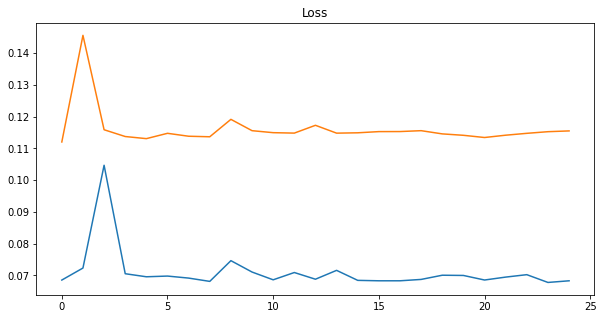

In [15]:
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(np.mean(losses, axis = 0),label="train_loss")
plt.plot(np.mean(val_losses, axis = 0),label="val_loss")